In [1]:
# Transforming the ALFRED dataset
from utils import *

ALFRED_JSON_PATTERN = '../datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json' 
train_dataset = load_next_alfred_data(ALFRED_JSON_PATTERN)
print('train dataset size: ', len(train_dataset))
print('%3f kb' % (sys.getsizeof(train_dataset) / 1024.0))


100%|██████████| 255/255 [00:02<00:00, 87.17it/s]

train dataset size:  255
2.171875 kb


In [ ]:
# OPTIONAL: Filter dataset

import random

dataset25 = filtered_dataset_copy(train_dataset, 'FloorPlan25')
# A little random sample for testing
print('dataset samples: ', len(dataset25))
for i in range(1):
    print('*' * 20)
    example = dataset25[0] #random.choice(dataset25)
    #print(example[1]['floor_plan'])
    #print(example[1]['object_poses'])
    print(example[1]['task_id'])
    for j in example[0]:
        print('-' * 20)
        print(j['task_desc'])
        print(j['instructions'])

# Instruction Dot Test
Use the dot product between words and semantic graph. 

TODO:
* Use cosine similarity for scoring, instead of dot product. [DONE]
* Normalise affordance features after adding parent representions. [DONE, Note: I averaged affordance features by dividing by 2.0]
* Remove puncuation from the instructions. [DONE, removes ('), (,), (.)]
* Remove / Control instruction quality by thresholding votes [DONE, during processing removes any instructions without unanimous votes]
* New test: Only use environments where all objects already exist within the graph. [DONE]
* Pie chart showing percents on target action [DONE]
* Add interactive prompt mode. [DONE]
* Histogram on instruction length and performance ratio [DONE]
* DO NOT use hash to save files. Hash resets on python interpreters for security. Use cryptohash if required. Alternatively, just use the filenames if possible? [DONE]
* DOCUMENT ALL TESTS IN THEIR FOLDERS WITH SOURCE DATA [DONE]
* Seperate function into modular groups. [DONE]

Visualisation patch:
* Replace "Most failed actions" with pie chart showing test action composition [IGNORE]
* Bar chart of cosine scores for a single trajectory [IGNORE, only works on local (small) graphs]

Performance patch:
* Use vibs codebook lookup to store indices instead of word vectors. Only change pickle loading functions.

Experiments TODO:
* Redo test: On hot vectors [IGNORE]

Future:
* Use MODERN graph REPRESENTATION. without the hundrends of pose nodes! [PRIORITY]
* Redo trajectory test: Cancel trajectories as soon as a single instruction fails
* Instead of adding object features to affordance features score them seperately on nouns and verbs respectively then sum them together for a final score. Disregard determiner words and puncuation. 
* Add a distance scaling factor around the robot_node after the first instruction.
* Add all simulator affordances/actions
* Assure that actions ARE performed. This means sometimes we have to scan our immediate surroundings to perform actions on. Example:Target: go -> sinkbasin, Actual: go -> sinkbasin [True] PickupObject False  Fork|-01.97|+00.70|+00.30 is not visible. Target: pick -> fork, Actual: pick -> fork [True]
* Analyse the mindmeld NLP pipeline for seeing how far we can make this a real product project. I.e. Intent classification. Entity classification. Entity Role Assignment. WSB, POS, NER, entity resolution. 


In [2]:
from models import *

m = CosineModel()
class T:
    x = torch.randn(4,10)
    edge_index = torch.randn(2, 4)

t = T()
m(t, torch.randn(10,10))


(tensor([[0.7739],
         [0.3364],
         [0.3111],
         [1.7328]]),
 [tensor(0),
  tensor(2),
  tensor(3),
  tensor(3),
  tensor(3),
  tensor(2),
  tensor(3),
  tensor(0),
  tensor(1),
  tensor(3)])

In [4]:
# import ai2thor
import ai2thor.controller
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import torchtext

import pandas as pd
import json, pickle, time
from tqdm.notebook import trange, tqdm

print(ai2thor.__version__)
# word_vec = torchtext.vocab.FastText()
# controller = ai2thor.controller.Controller(scene='FloorPlan29', grid_size=0.25, visibilityDistance=0.75, quality='Very Low', headless=False)   
controller = ai2thor.controller.Controller('Very Low', False, True) #dict(scene='FloorPlan25', grid_size=0.25, visibilityDistance=0.75)) #, quality='Very Low', headless=True))
controller.start()
controller.step(dict(action='Initialize', grid_size=0.25, headless=True, visibilityDistance=0.75))
event = controller.step(dict(action='Pass'))
controller.reset('FloorPlan25')

#%run scene_graph.ipynb
#%run thorEnvironment.ipynb
from thor_environment import *

import os
import random
import networkx as nx
import matplotlib.pyplot as plt
import copy

from utils import *

# Seed for reproduceability
np.random.seed(42)
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using: ',device)

# Experiment parameters
debug_instructions = False
debug_scores = False
debug_log = True
subset = train_dataset[:]
model = CosineModel().to(device)

# The test is for a multiple instructions intended to be executed over multiple timesteps of length 1
max_timesteps = 1 # TODO: Consider increasing to increase performance, niko used 10 i think.
reward = []
used_timesteps = []
trajectory_success = []
instruction_success = []
task_number = 0

# Experiment Log
if debug_log:
    debug_log_file = open('baseline_debug_log.tsv', 'w')
    debug_log_file.write("scene \t instruction \t expected_object \t expected_affordance \t actual_object \t actual_affordance \t success\n")

# run for each instruction in a task
for task in subset:
    trajectories, scene = task
    
    scene_name = "FloorPlan%d" % scene['scene_num']
    task_id = scene['task_id']
    object_poses = scene['object_poses']
    object_toggles = scene['object_toggles']
    dirty_and_empty = scene['dirty_and_empty']
    init_action = scene['init_action']
    
    # ALFRED has a custom initialised scene for each task
    # This is expensive, every task requires new initalisations and therefore new explorations
    environment_file = "../saved_environments/{}_{}.gz".format(scene_name, task_id)
    
    episode = {'log_probs':[], 'rewards':[], 'timesteps':0, 'entropy':[]}
    done = False
    t = 0
    task_number += 1
    print(" --- %d / %d --- %s" % (task_number, len(subset), task_id))
    
    for traj_idx, traj in enumerate(trajectories):
        # Each trajectory in a task uses the same environment but must be reset
        # each trajectory.
        controller.reset(scene_name)
        env = ThorEnvironment(controller=controller)
        
        if os.path.isfile(environment_file):
            # load file, if exists
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Loading environment...')
            env.graph = env.graph.from_pickle(environment_file)
            if not hasattr(env.graph, 'robot_node'):
                env.graph.setup()
            print('Done')
        else:
            # explore and save
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Exploring environment...')
            env.explore_environment()
            env.graph.setup()
            print('Saving environment...')
            env.graph.to_pickle(environment_file)
            print('Done')
        
        ###########################################################
        # The following continue statement is here to make sure all
        # we are doing is exploring environments for caching.
        # Exploring and then using those graphs could (should) cause
        # this script to crash right now. So instead ill just explore
        # then once that is done I will fix the crash code where we 
        # use the graph. Since the graphs will be cached testing
        # will be quicker!
        ###########################################################
        #continue
        #draw_graph(env.graph)
        #assert False
        
        complete_trajectory = True
        
        if not valid_trajectory(env, traj):
            print('[CHECK] Invalid trajectory. Skipping...')
            continue
        else:
            print('[CHECK] Valid Trajectory!')
        
        if debug_instructions:
            print("Task Trajectory: %d / %d (%d instructions)" % (traj_idx+1, len(trajectories), len(traj['instructions'])))
            print('High level objective: %s | Task Num: %s' % (traj['task_desc'], task_id))
        
        for inst_idx, instruction in enumerate(traj['instructions']):
            if debug_instructions:
                print('-----> Instruction %d / %d' % (inst_idx + 1, len(traj['instructions'])))            
            
            target_object = instruction['argument_1']
            target_affordance = instruction['action']
            
            if debug_instructions:
                print("Target affordance: %s -> %s\nTarget Instruction: %s" % (instruction['action'], target_object, ' '.join(instruction['instruction'])))
            target_embedding = [env.graph.word2vec(word.lower()) for word in instruction['instruction']]

            #done = False
            for timestep in range(max_timesteps):
                
                env.graph.to_torch_graph()

                # Experimental, adds the object features to the affordances
                object_smooth_graph = add_object_features(env.graph)

                # run the policy network
                target = torch.tensor(target_embedding, dtype=torch.float).to(device)
                #logits = model(env.graph._torch_graph.to(device), target).t()
                logits, max_affordances = model(object_smooth_graph, target)
                logits = logits.t()
                
                # we only care about the affordance nodes, so set the logits of all other nodes to something very small
                mask = torch.tensor(env.graph._torch_affordance_mask==0, dtype=torch.bool).view(1,-1).to(device)
                logits[mask] = -1000
                
                # Debug model scores
                if debug_scores:
                    node_names = []
                    for n in max_affordances:
                        if env.graph.nodes[n.item()]['node_type'] == 'affordance':
                            node_names.append(env.graph.nodes[n.item()]['affordance'])
                        elif env.graph.nodes[n.item()]['node_type'] == 'object':
                            node_names.append(env.graph.nodes[n.item()]['obj'])
                    graph_word_scores([word.lower() for word in instruction['instruction']], node_names)
                
                
                # sample an action from the output of the model
                action = torch.argmax(logits)
                affordance = env.graph.from_torch_id(action.item())
                
                correct_affordance = False
                actual_affordance = env.graph.nodes[affordance]['affordance']
                                
                if actual_affordance == normalize_action_name(target_affordance):
                    correct_affordance = True
                
                r = 0.0
                succ, pred = env.graph.get_related_objects(affordance)
                
                correct_object = False
                actual_object = None
                
                if not pred is None:
                    for n in pred:
                        actual_object = env.graph.nodes[n]['obj']
                        if actual_object == target_object:
                            if correct_affordance:
                                r = 1.0
                                #done = True
                                correct_object = True
                                env.step(action.item()) # An Action is an affordance in the graph
                                # TODO: If action cannot be executed, break loop and print error. 
                                break
                
                print("Target: %s -> %s \t Actual: %s -> %s [%s]" % (normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_affordance and correct_object))
                
                if correct_affordance and correct_object:
                    instruction_success.append((1.0, normalize_action_name(target_affordance), len(target_embedding)))
                else:
                    complete_trajectory = False
                    instruction_success.append((0.0, normalize_action_name(target_affordance), len(target_embedding)))
                
                if debug_log:
                    debug_log_file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (scene_name, ' '.join(instruction['instruction']), normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_object and correct_affordance))
                
                episode['rewards'].append(r)
                episode['timesteps'] = t
        
        if complete_trajectory:
            trajectory_success.append(1.0)
        else:
            trajectory_success.append(0.0)
    
    # === end of an episode ===
    used_timesteps.append(t)
    
    reward.append(np.sum(episode['rewards']))

if debug_log:
    debug_log_file.close()

2.1.0
Using:  cpu
 --- 1 / 255 --- trial_T20190908_145356_918528
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Target: go -> garbagecan 	 Actual: put -> garbagecan [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: put -> countertop [False]
Target: heat -> apple 	 Actual: put -> countertop [False]
Target: go -> garbagecan 	 Actual: go -> papertowelroll [False]
Target: put -> apple 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> garbagecan 	 Actual: go -> countertop [False]
Target: pick -> apple 	 Actual: put -> garbagecan [False]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> apple 	 Actual: put -> countertop [False]
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
Target: put -> apple 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Vali

Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sofa [True]
Target: pick -> creditcard 	 Actual: pick -> creditcard [True]
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: put -> sidetable [False]
Target: pick -> creditcard 	 Actual: pick -> watch [False]
Target: go -> floorlamp 	 Actual: put -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 8 / 255 --- trial_T20190909_103628_479585
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: put -> sidetable [False]
Target: pick -> creditcard 	 Actual: pick -> pillow [False]
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sidetable [False]
Target: pic

Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> fridge 	 Actual: go -> faucet [False]
Target: cool -> tomato 	 Actual: open -> fridge [False]
Target: go -> microwave 	 Actual: put -> countertop [False]
Target: put -> tomato 	 Actual: open -> fridge [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> fridge 	 Actual: put -> fridge [False]
Target: cool -> tomato 	 Actual: put -> fridge [False]
Target: go -> microwave 	 Actual: go -> tomato [False]
Target: put -> tomato 	 Actual: cook -> potato [False]
 --- 15 / 255 --- trial_T20

Target: pick -> cup 	 Actual: pick -> knife [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: put -> cup 	 Actual: put -> sinkbasin [False]
 --- 19 / 255 --- trial_T20190907_050942_897916
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: go -> desk [True]
Target: pick -> cd 	 Actual: put -> desk [False]
Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> cd 	 Actual: put -> safe [False]
Target: go -> desk 	 Actual: go -> desk [True]
Target: pick -> cd 	 Actual: go -> desk [False]
Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> cd 	 Actual: put -> safe [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> desk 	 Actual: break -> window [False]
Target: pick -> cd 	 Actual: pick -> cd [True]
Target: go -> safe 	 Actual: break -> mirror [False]
Target: put -> cd 	 Actual: go -> cd [False]
Target: go -> desk 	 Actual: put -> bed [False]
Target: pick -> cd 	 Actual: pick -> cd [True]
T

Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> apple 	 Actual: go -> glassbottle [False]
Target: slice -> apple 	 Actual: break -> vase [False]
Target: go -> garbagecan 	 Actual: go -> knife [False]
Target: put -> knife 	 Actual: put -> garbagecan [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> apple 	 Actual: close -> fridge [False]
Target: go -> garbagecan 	 Actual: go -> fridge [False]
Target: put -> apple 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> knife 	 Actual: pick -> bread [False]
Target: go -> apple 	 Actual: put -> toaster [False]
Target: slice -> apple 	 Actual: slice -> apple [True]
Target

Target: go -> coffeemachine 	 Actual: go -> window [False]
Target: put -> mug 	 Actual: put -> coffeemachine [False]
 --- 29 / 255 --- trial_T20190907_183853_958104
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> mug 	 Actual: close -> fridge [False]
Target: go -> coffeemachine 	 Actual: go -> faucet [False]
Target: put -> mug 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> mug 	 Actual: put -> coffeemachine [False]
Target: go -> coffeemachine 	 Actual: go -> faucet [False]
Target: put -> mug 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Targ

Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> bread 	 Actual: put -> countertop [False]
Target: pick -> knife 	 Actual: go -> knife [False]
Target: slice -> bread 	 Actual: slice -> bread [True]
Target: put -> knife 	 Actual: put -> countertop [False]
Target: pick -> bread 	 Actual: slice -> bread [False]
Target: go -> microwave 	 Actual: go -> faucet [False]
Target: heat -> bread 	 Actual: go -> bread [False]
Target: go -> countertop 	 Actual: break -> window [False]
Target: put -> bread 	 Actual: go -> bread [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> bread 	 Actual: pick -> bread [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> bread 	 Actual: go -> bread [False]
Target: pick -> knife 	 Actual: pick -> bread [False]
Target: slice -

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> toilet 	 Actual: put -> sinkbasin [False]
Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
Target: go -> garbagecan 	 Actual: put -> garbagecan [False]
Target: put -> soapbar 	 Actual: put -> garbagecan [False]
Target: go -> toilet 	 Actual: go -> plunger [False]
Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
Target: go -> garbagecan 	 Actual: put -> garbagecan [False]
Target: put -> soapbar 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> toilet 	 Actual: go -> toilet [True]
Target: pick -> soapbar 	 Actual: put -> toilet [False]
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
Target: put -> soapbar 	 Actual: put -> garbagecan [False]
Target: go -> toilet 	 Actual: go -> toilet [True]
Target: pick -> soapbar 	 Actual: put -> toilet [False]
Target: go -> garbagecan 	 Actual: go -> garbagecan [True]
Target: put -> soapbar 	 Actua

[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> butterknife 	 Actual: go -> knife [False]
Target: go -> lettuce 	 Actual: go -> fridge [False]
Target: slice -> lettuce 	 Actual: put -> fridge [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: put -> butterknife 	 Actual: put -> fridge [False]
Target: go -> fridge 	 Actual: close -> fridge [False]
Target: pick -> lettuce 	 Actual: open -> fridge [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> lettuce 	 Actual: go -> bread [False]
Target: g

Target: go -> countertop 	 Actual: put -> coffeemachine [False]
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> microwave 	 Actual: put -> countertop [False]
Target: heat -> mug 	 Actual: close -> fridge [False]
Target: go -> coffeemachine 	 Actual: go -> countertop [False]
Target: put -> mug 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> pot [False]
Target: pick -> mug 	 Actual: put -> coffeemachine [False]
Target: go -> microwave 	 Actual: put -> cup [False]
Target: heat -> mug 	 Actual: put -> coffeemachine [False]
Target: go -> coffeemachine 	 Actual: put -> coffeemachine [False]
Target: put -> mug 	 Actual: go -> pot [False]
 --- 48 / 255 --- trial_T20190907_171933_349922
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being foun

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> bread 	 Actual: pick -> bread [True]
Target: go -> fridge 	 Actual: put -> fridge [False]
Target: cool -> bread 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: go -> bread [False]
Target: put -> bread 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> bread 	 Actual: go -> bread [False]
Target: go -> fridge 	 Actual: break -> window [False]
Target: cool -> bread 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> bread 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> window [False]
Target: pick -> bread 	 Actual: pick -> bread [True]
Target: go -> fridge 	 Actual: close -> fridge [False]

Target: put -> butterknife 	 Actual: put -> countertop [False]
Target: pick -> cup 	 Actual: close -> drawer [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> cup 	 Actual: put -> cup [True]
 --- 59 / 255 --- trial_T20190908_235816_620828
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> butterknife 	 Actual: pick -> butterknife [True]
Target: go -> cup 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> sinkbasin [False]
Target: pick -> cup 	 Actual: pick -> cup [True]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> cup 	 Actual: put -> cup [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> cup 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> cup [Fa

Target: put -> potato 	 Actual: go -> houseplant [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> potato 	 Actual: go -> countertop [False]
Target: go -> garbagecan 	 Actual: go -> countertop [False]
Target: put -> potato 	 Actual: go -> houseplant [False]
 --- 66 / 255 --- trial_T20190907_161745_664033
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> faucet [False]
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> potato 	 Actual: cook -> potato [False]
Target: go 

Target: put -> egg 	 Actual: put -> bowl [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
Target: pick -> bowl 	 Actual: break -> plate [False]
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
Target: put -> bowl 	 Actual: put -> cup [False]
Target: pick -> egg 	 Actual: break -> mug [False]
Target: put -> egg 	 Actual: put -> cup [False]
 --- 72 / 255 --- trial_T20190908_062352_374890
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> egg 	 Actual: pick -> bread [False]
Target: go -> bowl 	 Actual: break -> egg [False]
Target: put -> egg 

Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> tomato 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> tomato 	 Actual: go -> stoveknob [False]
Target: slice -> tomato 	 Actual: go -> knife [False]
Target: go -> fridge 	 Actual: go -> knife [False]
Target: put -> butterknife 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: go -> potato [False]
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> fridge 	 Actual: put -> fridge [False]
Target: cool -> tomato 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: go -> butterknife [False]
Target: put -> tomato 	 Actual: slice -> potato [False]
 --- 77 / 255 --- trial_T20190909_061805_153515
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [T

Target: go -> countertop 	 Actual: go -> coffeemachine [False]
Target: put -> apple 	 Actual: go -> apple [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> countertop 	 Actual: go -> coffeemachine [False]
Target: put -> apple 	 Actual: put -> coffeemachine [False]
Target: go -> countertop 	 Actual: go -> knife [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> apple 	 Actual: go -> coffeemachine [False]
Target: slice -> apple 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
Target: put -> apple 	 Actual: put -> coffeemachine [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> counterto

Target: pick -> knife 	 Actual: pick -> knife [True]
Target: slice -> apple 	 Actual: put -> countertop [False]
Target: go -> apple 	 Actual: put -> sinkbasin [False]
Target: slice -> apple 	 Actual: put -> sinkbasin [False]
Target: put -> knife 	 Actual: put -> sinkbasin [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> apple 	 Actual: go -> apple [False]
 --- 82 / 255 --- trial_T20190909_174807_646433
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> lettuce 	 Actual: pick -> lettuce [True]
Target: go -> fridge 	 Actual: put -> fridge [False]
Target: cool -> lettuce 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> lettuce 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> counterto

Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: pick -> tissuebox 	 Actual: close -> box [False]
Target: go -> floorlamp 	 Actual: go -> sofa [False]
Target: toggle -> floorlamp 	 Actual: put -> sofa [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: put -> dresser [False]
Target: pick -> tissuebox 	 Actual: close -> cabinet [False]
Target: go -> floorlamp 	 Actual: put -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: put -> sofa [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: break -> statue [False]
Target: pick -> tissuebox 	 Actual: put -> box [False]
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 89 / 255 --- trial_T20190906_213948_501157
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: put -> dresser [False]
Target: pick -> tissuebox 	 Actual: pick -> tissueb

Target: pick -> plate 	 Actual: put -> plate [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: put -> plate 	 Actual: put -> plate [True]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: go -> window [False]
Target: pick -> glassbottle 	 Actual: put -> coffeemachine [False]
Target: go -> plate 	 Actual: go -> countertop [False]
Target: put -> glassbottle 	 Actual: put -> plate [False]
Target: pick -> plate 	 Actual: put -> plate [False]
Target: go -> sinkbasin 	 Actual: go -> window [False]
Target: put -> plate 	 Actual: break -> plate [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to grap

Target: put -> knife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> stoveknob [False]
Target: heat -> apple 	 Actual: slice -> apple [False]
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
Target: put -> apple 	 Actual: slice -> apple [False]
 --- 99 / 255 --- trial_T20190908_131500_521936
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> apple 	 Actual: go -> sink [False]
Target: slice -> apple 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> sinkbasin [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> countertop [False]

[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> microwave 	 Actual: go -> faucet [False]
Target: pick -> cup 	 Actual: open -> fridge [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: put -> cup 	 Actual: put -> sinkbasin [False]
Target: pick -> fork 	 Actual: put -> sinkbasin [False]
Target: put -> fork 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> microwave 	 Actual: go -> stoveknob [False]
Target: pick -> cup 	 Actual: open -> fridge [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: put -> cup

Target: go -> armchair 	 Actual: go -> watch [False]
Target: pick -> pillow 	 Actual: pick -> pillow [True]
Target: go -> sofa 	 Actual: go -> sidetable [False]
Target: put -> pillow 	 Actual: put -> sidetable [False]
 --- 109 / 255 --- trial_T20190907_040303_217739
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> lettuce 	 Actual: pick -> butterknife [False]
Target: go -> fridge 	 Actual: go -> faucet [False]
Target: cool -> lettuce 	 Actual: close -> fridge [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: put -> lettuce 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> lettuce 	 Actual: put -> coffeemachine [False]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> lettuce 	 Actual: open -> fridge [False]
Target: go -> sinkbasin 	 Actual: go -> s

Target: go -> fridge 	 Actual: go -> faucet [False]
Target: put -> apple 	 Actual: open -> fridge [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: pick -> apple 	 Actual: pick -> spoon [False]
Target: go -> microwave 	 Actual: put -> stoveburner [False]
Target: heat -> apple 	 Actual: open -> fridge [False]
Target: go -> fridge 	 Actual: close -> fridge [False]
Target: put -> apple 	 Actual: open -> fridge [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> apple 	 Actual: pick -> apple [False]
Target: go -> fridge 	 Actu

Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> knife 	 Actual: put -> countertop [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> bread 	 Actual: go -> bread [False]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> bread 	 Actual: close -> fridge [False]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: put -> bread 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> bread 	 Actual: go -> bread [True]
Target: slice -> bread 	 Actual: slice -> bread [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> knife 	 Actual: put -> countertop [False]
Target: go -> countertop 	 Actual: put -> countertop [False]


Target: put -> mug 	 Actual: put -> coffeemachine [False]
 --- 122 / 255 --- trial_T20190907_221355_558505
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> window [False]
Target: pick -> mug 	 Actual: pick -> vase [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: clean -> mug 	 Actual: put -> coffeemachine [False]
Target: go -> coffeemachine 	 Actual: put -> coffeemachine [False]
Target: put -> mug 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> window [False]
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: clean -> mug 	 Actual: pick -> mug [False]
Target: go -> coffeemachine 	 Actual: put -> coffeemachine [False]
Target: put -> mug 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual:

Target: put -> watch 	 Actual: close -> box [False]
 --- 130 / 255 --- trial_T20190908_111818_332166
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> window [False]
Target: pick -> fork 	 Actual: put -> countertop [False]
Target: go -> cup 	 Actual: go -> faucet [False]
Target: put -> fork 	 Actual: open -> fridge [False]
Target: pick -> cup 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> cup 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK][NOTE] - Target foun

Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> butterknife 	 Actual: put -> countertop [False]
Target: go -> tomato 	 Actual: put -> countertop [False]
Target: slice -> tomato 	 Actual: slice -> potato [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> tomato 	 Actual: put -> countertop [False]
Target: go -> microwave 	 Actual: put -> countertop [False]
Target: heat -> tomato 	 Actual: pick -> tomato [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: put -> tomato 	 Actual: slice -> potato [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> window [False]
Target: pick -> butterknife 	 Actual: put -> countertop [False]
Target: go

Target: clean -> cloth 	 Actual: go -> faucet [False]
Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: put -> cloth 	 Actual: go -> cabinet [False]
 --- 140 / 255 --- trial_T20190908_022321_380927
Loading environment...
Done
[CHECK] Valid Trajectory!
zero word: handtowelholder
Target: go -> cloth 	 Actual: go -> cloth [True]
Target: pick -> cloth 	 Actual: pick -> cloth [True]
Target: go -> sinkbasin 	 Actual: go -> cabinet [False]
Target: clean -> cloth 	 Actual: go -> cabinet [False]
zero word: handtowelholder
Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: put -> cloth 	 Actual: go -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cloth 	 Actual: put -> sinkbasin [False]
Target: pick -> cloth 	 Actual: pick -> plunger [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: clean -> cloth 	 Actual: put -> sinkbasin [False]
Target: go -> cabinet 	 Actual: go -> sinkbasin [False]
Target: put -> cloth 	 Act

Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
Target: go -> cabinet 	 Actual: break -> mirror [False]
Target: put -> soapbar 	 Actual: close -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: put -> soapbar 	 Actual: open -> cabinet [False]
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
Target: go -> cabinet 	 Actual: go -> cabinet [True]
Target: put -> soapbar 	 Actual: open -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> soapbar 	 Actual: pick -> soapbottle [False]
Target: go -> cabinet 	 Actual: put -> sinkbasin [False]
Target: put -> soapbar 	 Actual: put -> cabinet [False]
Target: go -> countertop

Target: go -> desklamp 	 Actual: go -> window [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> basketball 	 Actual: put -> bed [False]
Target: pick -> basketball 	 Actual: pick -> basketball [True]
Target: go -> desklamp 	 Actual: go -> window [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
 --- 152 / 255 --- trial_T20190907_161210_531813
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> basketball 	 Actual: go -> bed [False]
Target: pick -> basketball 	 Actual: pick -> basketball [True]
Target: go -> desklamp 	 Actual: go -> desk [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> basketball 	 Actual: put -> bed [False]
Target: pick -> basketball 	 Actual: pick -> basketball [True]
Target: go -> desklamp 	 Actual: put -> bed [False]
Target: toggle -> desklamp 	 Actual: go -> desk

Target: go -> shelf 	 Actual: go -> sidetable [False]
Target: pick -> box 	 Actual: pick -> box [True]
Target: go -> floorlamp 	 Actual: put -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: go -> lamp [False]
 --- 159 / 255 --- trial_T20190907_103005_855069
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sidetable [False]
Target: pick -> box 	 Actual: pick -> box [True]
Target: go -> floorlamp 	 Actual: put -> sofa [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sofa [True]
Target: pick -> box 	 Actual: put -> sofa [False]
Target: go -> floorlamp 	 Actual: go -> floorlamp [True]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sidetable [False]
Target: pick -> box 	 Actual: pick -> box [True]
Target: go -> floorlamp 	 Actual: 

Target: pick -> egg 	 Actual: pick -> plate [False]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> egg 	 Actual: open -> fridge [False]
Target: go -> garbagecan 	 Actual: put -> sinkbasin [False]
Target: put -> egg 	 Actual: go -> egg [False]
 --- 164 / 255 --- trial_T20190908_113523_123938
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> garbagecan 	 Actual: go -> faucet [False]
Target: pick -> egg 	 Actual: put -> garbagecan [False]
Target: go -> microwave 	 Actual: go -> window [False]
Target: heat -> egg 	 Actual: go -> stoveknob [False]
Target: go -> garbagecan 	 Actual: put -> garbagecan [False]
Target: put -> egg 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> garbagecan 	 Actual

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
Target: pick -> peppershaker 	 Actual: pick -> butterknife [False]
Target: go -> drawer 	 Actual: put -> countertop [False]
Target: put -> peppershaker 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> window [False]
Target: pick -> peppershaker 	 Actual: pick -> butterknife [False]
Target: go -> drawer 	 Actual: close -> drawer [False]
Target: put -> peppershaker 	 Actual: close -> drawer [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> coffeemachine [False]
Target: pick -> peppershaker 	 Actual: pick -> butterknife [False]
Target: go -> drawer 	 Actual: go -> stoveknob [False]
Target: put -> peppershaker 	 Actual: put -> drawer [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> 

Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: go -> sidetable [False]
Target: pick -> keychain 	 Actual: pick -> statue [False]
Target: go -> safe 	 Actual: go -> sidetable [False]
Target: put -> keychain 	 Actual: put -> safe [False]
Target: go -> sofa 	 Actual: go -> sidetable [False]
Target: pick -> keychain 	 Actual: pick -> box [False]
Target: go -> safe 	 Actual: go -> safe [True]
Target: put -> keychain 	 Actual: put -> safe [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: close -> drawer [False]
Target: pick -> keychain 	 Actual: pick -> statue [False]
Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> keychain 	 Actual: close -> safe [False]
Target: go -> sofa 	 Actual: put -> sidetable [False]
Target: pick -> keychain 	 Actual: put -> sidetable [False]
Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> keychain 	 Actual: close -> safe [False]
Loading environment...
Done
[CHECK] Valid Traje

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> statue [False]
Target: pick -> spoon 	 Actual: pick -> spoon [True]
Target: go -> pan 	 Actual: go -> stoveknob [False]
Target: put -> spoon 	 Actual: go -> spoon [False]
Target: pick -> pan 	 Actual: pick -> spoon [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: put -> pan 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> spoon 	 Actual: put -> countertop [False]
Target: go -> pan 	 Actual: go -> window [False]
Target: put -> spoon 	 Actual: put -> plate [False]
Target: pick -> pan 	 Actual: pick -> plate [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: put -> pan 	 Actual: break -> plate [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> spoon 	 Actual: pick

[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> window [False]
Target: pick -> plate 	 Actual: pick -> plate [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> plate 	 Actual: put -> plate [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> plate 	 Actual: put -> plate [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> plate 	 Actual: pick -> plate [True]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> plate 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> stoveknob [False]
Target: put -> plate 	 Actual: put -> plate [True]
 --- 190 / 255 --- trial_T20190908_114656_768805
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> stoveburner 	 Actual: go -> faucet [False]
Target: pick -> pan 	 Actual: pick -> pan [True]
Target: go -> fridge 	 Actual: go -> fridg

Target: go -> safe 	 Actual: go -> shelf [False]
Target: put -> vase 	 Actual: put -> safe [False]
 --- 197 / 255 --- trial_T20190908_205246_776817
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> sidetable [False]
Target: pick -> vase 	 Actual: pick -> vase [True]
Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> vase 	 Actual: open -> safe [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: put -> sidetable [False]
Target: pick -> vase 	 Actual: pick -> statue [False]
Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> vase 	 Actual: put -> safe [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: put -> sidetable [False]
Target: pick -> vase 	 Actual: put -> shelf [False]
Target: go -> safe 	 Actual: put -> safe [False]
Target: put -> vase 	 Actual: put -> safe [False]
 --- 198 / 255 --- trial_T20190908_205204_244321
Loading environment...

Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sofa [True]
Target: pick -> newspaper 	 Actual: pick -> newspaper [True]
Target: go -> floorlamp 	 Actual: put -> sofa [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: put -> sidetable [False]
Target: pick -> newspaper 	 Actual: pick -> newspaper [True]
Target: go -> floorlamp 	 Actual: put -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sofa 	 Actual: go -> sidetable [False]
Target: pick -> newspaper 	 Actual: pick -> newspaper [True]
Target: go -> floorlamp 	 Actual: go -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
 --- 204 / 255 --- trial_T20190907_171035_866841
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: put -> sidetable [False]
Target:

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> baseballbat 	 Actual: go -> baseballbat [True]
Target: pick -> baseballbat 	 Actual: break -> window [False]
Target: go -> desklamp 	 Actual: go -> desk [False]
Target: toggle -> desklamp 	 Actual: put -> desk [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> baseballbat 	 Actual: break -> window [False]
Target: pick -> baseballbat 	 Actual: pick -> book [False]
Target: go -> desklamp 	 Actual: put -> bed [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> baseballbat 	 Actual: break -> window [False]
Target: pick -> baseballbat 	 Actual: pick -> book [False]
Target: go -> desklamp 	 Actual: put -> desk [False]
Target: toggle -> desklamp 	 Actual: put -> desk [False]
 --- 211 / 255 --- trial_T20190908_021537_611374
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> plunger 	 Actual: put -> toil

Target: go -> mug 	 Actual: go -> shelf [False]
Target: put -> spoon 	 Actual: put -> shelf [False]
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: put -> mug 	 Actual: put -> mug [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: break -> window [False]
Target: pick -> spoon 	 Actual: pick -> spoon [True]
Target: go -> mug 	 Actual: break -> window [False]
Target: put -> spoon 	 Actual: put -> countertop [False]
Target: pick -> mug 	 Actual: pick -> spoon [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: put -> mug 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> spoon 	 Actual: pick -> spoon [True]
Target: go -> mug 	 Actual: go -> shelf [False]
Target: put -> spoon 	 Actual: put -> cup [False]
Target: pick -> mug 	 Actual: pick -

Target: pick -> knife 	 Actual: pick -> plate [False]
Target: go -> sinkbasin 	 Actual: go -> bread [False]
Target: clean -> knife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: break -> glassbottle [False]
Target: put -> knife 	 Actual: put -> plate [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: clean -> knife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> knife [False]
Target: put -> knife 	 Actual: put -> plate [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> faucet [False]
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: clean -> knife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> window [Fal

Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: pick -> apple 	 Actual: pick -> egg [False]
Target: go -> microwave 	 Actual: go -> glassbottle [False]
Target: heat -> apple 	 Actual: pick -> apple [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: put -> apple 	 Actual: put -> sinkbasin [False]
 --- 226 / 255 --- trial_T20190907_083429_887065
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> cabinet 	 Actual: put -> countertop [False]
Target: pick -> cup 	 Actual: close -> cabinet [False]
Target: go -> microwave 	 Actual: go -> stoveknob [False]
Target: heat -> cup 	 Actual: close -> fridge [False]
Target: go -> cabinet 	 Actual: put -> countertop [False]
Target: put -> cup 	 Actual: open -> cabinet [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploratio

Target: go -> desklamp 	 Actual: go -> window [False]
Target: toggle -> desklamp 	 Actual: go -> desklamp [False]
 --- 232 / 255 --- trial_T20190912_221016_460197
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> peppershaker 	 Actual: pick -> saltshaker [False]
Target: go -> drawer 	 Actual: break -> window [False]
Target: put -> peppershaker 	 Actual: close -> drawer [False]
Target: go -> countertop 	 Actual: go -> drawer [False]
Target: pick -> peppershaker 	 Actual: pick -> saltshaker [False]
Target: go -> drawer 	 Actual: go -> countertop [False]
Target: put -> peppershaker 	 Actual: put -> drawer [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> peppershaker 	 Actual: pick -> butterknife [False]
Target: go -> drawer 	 Actual: break -> window [False]
Target: put -> peppershaker 	 Actual: close -> drawer [False]
Targ

Target: pick -> egg 	 Actual: break -> egg [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: clean -> egg 	 Actual: break -> egg [False]
Target: go -> microwave 	 Actual: go -> faucet [False]
Target: put -> egg 	 Actual: put -> countertop [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sink [False]
Target: pick -> egg 	 Actual: break -> egg [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: clean -> egg 	 Actual: put -> sinkbasin [False]
Target: go -> microwave 	 Actual: break -> egg [False]
Target: put -> egg 	 Actual: break -> egg [False]
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> egg 	 Actual: pick -> egg [Tru

Target: go -> fridge 	 Actual: go -> fridge [True]
Target: put -> potato 	 Actual: slice -> potato [False]
 --- 241 / 255 --- trial_T20190906_191429_743650
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
Target: pick -> saltshaker 	 Actual: pick -> saltshaker [True]
Target: go -> cabinet 	 Actual: put -> countertop [False]
Target: put -> saltshaker 	 Actual: open -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: go -> shelf [True]
Target: pick -> saltshaker 	 Actual: put -> shelf [False]
Target: go -> cabinet 	 Actual: go -> fridge [False]
Target: put -> saltshaker 	 Actual: put -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> shelf 	 Actual: put -> countertop [False]
Target: pick -> saltshaker 	 Actual: pick -> butterknife [False]
Target: go -> cabinet 	 Actual: put -> cabinet [False]
Target: put -> saltshaker 	 Actual: put -> cabinet [False

Target: put -> lettuce 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> lettuce 	 Actual: put -> countertop [False]
Target: slice -> lettuce 	 Actual: put -> countertop [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: put -> butterknife 	 Actual: put -> shelf [False]
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> lettuce 	 Actual: pick -> bread [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: cool -> lettuce 	 Actual: close -> fridge [False]
Target: go -> garbagecan 	 Actual: go -> window [False]
Target: put -> lettuce 	 Actual: put -> coffeemachine [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> lettuce 	 A

Target: go -> dresser 	 Actual: go -> sidetable [False]
Target: pick -> laptop 	 Actual: put -> sidetable [False]
Target: go -> floorlamp 	 Actual: put -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: go -> floorlamp [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: put -> cabinet [False]
Target: pick -> laptop 	 Actual: close -> drawer [False]
Target: go -> floorlamp 	 Actual: put -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: put -> sidetable [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: go -> dresser [True]
Target: pick -> laptop 	 Actual: close -> laptop [False]
Target: go -> floorlamp 	 Actual: go -> sidetable [False]
Target: toggle -> floorlamp 	 Actual: put -> sidetable [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> dresser 	 Actual: put -> sidetable [False]
Target: pick -> laptop 	 Actual: put -> sidetable [False]
Target: go -> floorlamp

Visualise Baseline Performance
-----------------------------

Tasks:  255
Trajectories:  821
Instructions:  5140
Failure:  {'go': 2028.0, 'pick': 637.0, 'heat': 136.0, 'put': 891.0, 'cool': 109.0, 'toggle': 173.0, 'clean': 103.0, 'slice': 48.0}
Success:  {'go': 423.0, 'pick': 479.0, 'heat': 0.0, 'put': 46.0, 'cool': 0.0, 'toggle': 0.0, 'clean': 10.0, 'slice': 57.0}
[[ 423.  479.    0.   46.    0.    0.   10.   57.]
 [2028.  637.  136.  891.  109.  173.  103.   48.]]


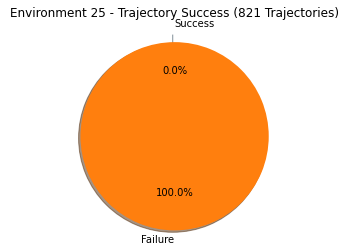

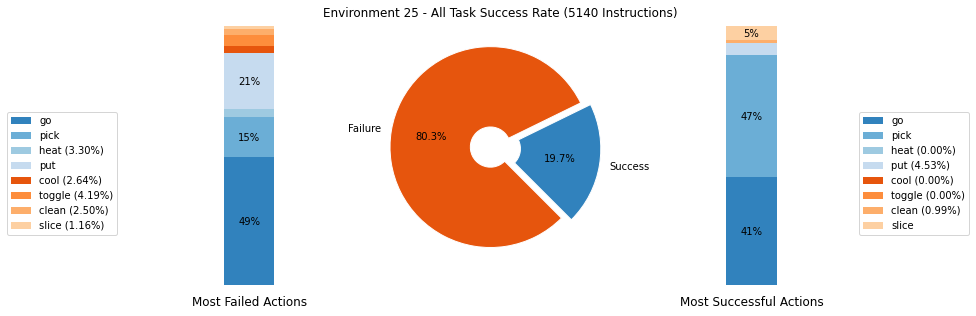

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

success = instruction_success

print("Tasks: ", len(subset))
print("Trajectories: ", len(trajectory_success))
print("Instructions: ", len(instruction_success))

succ_sum = 0
for i in success:
    succ_sum += i[0]

save_figures = True

# Trajectory pie chart
traj_success_count = sum(trajectory_success)
traj_fail_count = len(trajectory_success) - traj_success_count
fig1, ax1 = plt.subplots()
ax1.pie([traj_success_count, traj_fail_count], explode=(0.0,0.1), labels=['Success','Failure'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title='Environment 25 - Trajectory Success (%d Trajectories)' % len(trajectory_success))
if save_figures:
    plt.savefig('Environment 25 - Trajectory Success.png', dpi=300, bbox_inches='tight')

# Instruction pie and bar chart
action_failure = {}
action_success = {}
task_instruction_lengths = {}

for i in success:
    if not i[1] in action_success:
        action_success[i[1]] = 0.0
    if not i[1] in action_failure:
        action_failure[i[1]] = 0.0
    if not i[1] in task_instruction_lengths:
        task_instruction_lengths[i[1]] = []
    if i[0] == 1.0:
        action_success[i[1]] += 1.0
    else:
        action_failure[i[1]] += 1.0
    task_instruction_lengths[i[1]].append(i[2])

action_list = list(action_success.keys())

print('Failure: ', action_failure)
print('Success: ', action_success)

# make figure and assign axis objects
fig = plt.figure(figsize=(9+4.5, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.subplots_adjust(wspace=0)

size = 0.2
vals = np.array([list(action_success.values()), list(action_failure.values())])
print(vals)

cmap = plt.get_cmap("tab20c")
pie_colors = cmap(np.arange(3)*4)
bar_colors = cmap(np.arange(8))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / np.sum(vals[1]) for i in vals[1]] #Failure values
width = .2
fail_labels = action_list[:]

for j in range(len(ratios)):
    height = ratios[j]
    ax1.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax1.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.1:
        ax1.text(xpos, ypos - 0.015, "%d%%" % (ax1.patches[j].get_height() * 100),
                 ha='center')
    else:
        fail_labels[j] = "{} ({:.2f}%)".format(fail_labels[j], ratios[j] * 100.0)

ax1.set_title('Most Failed Actions', y=-0.1)
ax1.legend(fail_labels, bbox_to_anchor=(0,0.25), loc="lower left",  bbox_transform=fig.transFigure)
ax1.axis('off')
ax1.set_xlim(- 2.5 * width, 2.5 * width)

# pie chart parameters
ax2.pie(vals.sum(axis=1), explode=(0.0,0.1), labels=('Success', 'Failure'), autopct='%1.1f%%',
        shadow=False, startangle=-45, radius=1., colors=pie_colors, wedgeprops=dict(width=0.8, edgecolor='w'))

ax2.set(title='Environment 25 - All Task Success Rate (%d Instructions)' % len(success))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / succ_sum for i in vals[0]] #Success values
width = .2

for j in range(len(ratios)):
    height = ratios[j]
    ax3.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax3.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.05:
        ax3.text(xpos, ypos - 0.015, "%d%%" % (ax3.patches[j].get_height() * 100),
                 ha='center')
    else:
        action_list[j] = "{} ({:.2f}%)".format(action_list[j], ratios[j] * 100.0)

ax3.set_title('Most Successful Actions', y=-0.1)
ax3.legend(action_list, bbox_to_anchor=(1,0.25), loc="lower right",  bbox_transform=fig.transFigure)
ax3.axis('off')
ax3.set_xlim(- 2.5 * width, 2.5 * width)

#plt.tight_layout()
if save_figures:
    plt.savefig('dotnet-environment25-instructions-success.png', dpi=300, bbox_inches='tight')

In [ ]:
# Instruction Length Bar Chart
# Instruction length vs task success
plt.rcdefaults()
fig, ax = plt.subplots()

action_success_sorted = dict(sorted(action_success.items(), key=lambda item: item[1], reverse=True))
task_lengths_sorted = {}
for k in action_success_sorted.keys():
    task_lengths_sorted[k] = np.mean(task_instruction_lengths[k])

tasks = action_success_sorted.keys() # In order of success
y_pos = np.arange(len(tasks))
tasks_success = task_lengths_sorted.values()

ax.barh(y_pos, tasks_success, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(tasks)
ax.invert_yaxis()  # labels read top-to-bottom
rects = ax.patches
labels = ["%.2f%%" % ((i/succ_sum)*100.0) for i in action_success_sorted.values()]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + 0.55, label,
            ha='center', va='bottom')
ax.set_xlabel('Average Instruction Length')
ax.set_title('Comparing instruction length to task success')
if save_figures:
    plt.savefig('Comparing instruction length to task success.png', dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import cv2
import pathlib

#=========================================================
#import torchtext

# Load FastText word vectors
#fast_text = torchtext.vocab.FastText(cache='../.vector_cache')

# Load ALFRED training data using torchtext
import torchtext.data as data

#  Basic english normalisation, lowers and seperates grammar
INSTRUCTION = data.Field(tokenize='basic_english', lower=True,
                         init_token='<sos>',
                         eos_token='<eos>',)
ACTION = data.Field(is_target=True)
ACTION_ARGUMENT_1 = data.Field(tokenize='basic_english',is_target=True)
ACTION_ARGUMENT_2 = data.Field(tokenize='basic_english',is_target=True)

ALFRED_DATA_ROOT = '../honours_research_repo/'
ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Train_InstActionArgs.tsv'
ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Validation_InstActionArgs.tsv'
ALFRED_TEST_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Test_InstActionArgs.tsv'

def filter_action(example):
    if example.action[0] == 'PickupObject':
        return True
    else:
        return False

train, val, test = data.TabularDataset.splits(
    path='', 
    train=ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME,
    validation=ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME,
    test=ALFRED_TEST_INSTRUCTION_TSV_FILENAME, format='tsv',
    fields=[('trajectory_number', None),
            ('task_description', None),
            ('instruction_number', None),
            ('instruction', INSTRUCTION),
            ('action', ACTION),
            ('action_argument_1', ACTION_ARGUMENT_1),
            ('action_argument_2', ACTION_ARGUMENT_2)
           ], 
    filter_pred=filter_action)

INSTRUCTION.build_vocab(train,vectors=__word_vec__) #'fasttext.en.300d')
ACTION.build_vocab(train)
ACTION_ARGUMENT_1.build_vocab(train,vectors=__word_vec__)
ACTION_ARGUMENT_2.build_vocab(train,vectors=__word_vec__)
#=========================================================